In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.kernel_ridge import KernelRidge
from numpy.linalg import svd
from scipy import signal, stats
from scipy.stats import t
import h5py
import PIL
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

In [ ]:
def pearson_correlation_coefficient(x: np.ndarray, y: np.ndarray, axis: int) -> np.ndarray:
    r = (np.nan_to_num(stats.zscore(x)) * np.nan_to_num(stats.zscore(y))).mean(axis)
    p = 2 * t.sf(np.abs(r / np.sqrt((1 - r ** 2) / (x.shape[0] - 2))), x.shape[0] - 2)
    return r, p

In [ ]:
class KernelRidgeCV:
    def __init__(self, kernel, target, n_lambdas):
        self.kernel = kernel
        self.target = target
        self.n_lambdas = n_lambdas
        self._lambdas = None
        self._df = None

    @property
    def lambdas(self):
        if self._lambdas is not None:   
            return self._lambdas

        # Singular value decomposition
        s = svd(self.kernel)[1]
        s = s[s > 0]
        
        self._lambdas = np.full((self.n_lambdas), np.nan)
        length = s.shape[0]
        self._df = np.linspace(length, 1, self.n_lambdas)
        mean = np.mean(1/s)
        f = lambda df, lamb: df - np.sum(s / (s + lamb))
        f_prime = lambda lamb: np.sum(s / (s + lamb)**2)

        # Get all the lambdas
        for i in range(1, self.n_lambdas):
            if i == 1:
                self._lambdas[i] = 0
            else:
                self._lambdas[i] = self._lambdas[i-1]
            self._lambdas[i] = max(self._lambdas[i], (length / self._df[i] - 1) / mean)
            temp = f(self._df[i], self._lambdas[i])
            while abs(temp) > 1e-10:
                self._lambdas[i] = max(0, self._lambdas[i] - temp / f_prime(self._lambdas[i]))
                temp = f(self._df[i], self._lambdas[i])
        return self._lambdas[1:]


    def train(self, X):
        best_model, best_error = None, np.inf

        # CV over all the lambdas
        for lambda_, df_ in zip(self.lambdas, self._df):
            kernel_ridge = KernelRidge(alpha=lambda_)
            kernel_ridge.fit(X, self.target)
            y = kernel_ridge.predict(X)
            error = np.sum(((self.target - y) / (1 - df_ / self.kernel.shape[0])) ** 2)
            if error < best_error:
                best_error = error
                best_model = kernel_ridge
        print("Best error:", best_error, "Alpha: ", best_model.alpha)
        return best_model

In [ ]:
def features2responses(x_tr, f_te, f_tr, file_name):

    # n x n kernel matrix of pairwise similarity comparisons
    kernel = f_tr @ f_tr.T
    kernel = kernel.astype(float)

    y = np.zeros((100, 960))
    for roi in range(3):
        ridge_cv = KernelRidgeCV(kernel, x_tr[:, dims[roi]:dims[roi+1]], 5)
        model = ridge_cv.train(f_tr)
        y[:, dims[roi]:dims[roi+1]] = model.predict(f_te)
    np.save("/content/drive/My Drive/y_%s.npy" % file_name, y)

# Faces (StyleGAN3)

In [ ]:
f1 = h5py.File("/content/drive/My Drive/faces/GANs_StyleGAN3_normMUA.mat", "r")

# Delete broken microelectrode array
x_te = np.delete(np.array(f1["test_MUA"]), np.arange(320, 384), axis=1)
x_tr = np.delete(np.array(f1["train_MUA"]), np.arange(320, 384), axis=1)

# E.g., encoding from w-latents
w_te = np.load("/content/drive/My Drive/faces/w_te.npy")[:, 0]
w_tr = np.load("/content/drive/My Drive/faces/w_tr.npy")[:, 0]
features2responses(x_tr, w_te, w_tr, "faces_w_latents")

# E.g., encoding from CLIP latents
clip_te = np.load("/content/drive/My Drive/faces/clip_te.npy")
clip_tr = np.load("/content/drive/My Drive/faces/clip_tr.npy")
features2responses(x_tr, clip_te, clip_tr, "faces_clip_latents")

# Natural images (StyleGAN-XL)

In [ ]:
f1 = h5py.File("/content/drive/My Drive/images/GANs_StyleGAN_XL_normMUA.mat", "r")
dims = [0, 448, 704, 960]

# Delete broken microelectrode array
x_te = np.delete(np.array(f1["test_MUA"]), np.arange(320, 384), axis=1)
x_tr = np.delete(np.array(f1["train_MUA"]), np.arange(320, 384), axis=1)

# E.g., encoding from w-latents
w_te = np.load("/content/drive/My Drive/images/w_te.npy")[:, 0]
w_tr = np.load("/content/drive/My Drive/images/w_tr.npy")[:, 0]
features2responses(x_tr, w_te, w_tr, "images_w_latents")

# E.g., encoding from CLIP latents
clip_te = np.load("/content/drive/My Drive/images/clip_te.npy")
clip_tr = np.load("/content/drive/My Drive/images/clip_tr.npy")
features2responses(x_tr, clip_te, clip_tr, "images_clip_latents")

# Analysis

In [ ]:
# E.g., for natural images
y1 = np.load("/content/drive/My Drive/y_images_vgg16_1.npy")
y2 = np.load("/content/drive/My Drive/y_images_vgg16_3.npy")
y3 = np.load("/content/drive/My Drive/y_images_z_latents.npy")
y4 = np.load("/content/drive/My Drive/y_images_w_latents.npy")
y5 = np.load("/content/drive/My Drive/y_images_clip_latents.npy")
features = [y1, y2, y3, y4, y5]

rs_v1 = np.zeros((2, len(ys), 448))
rs_v4 = np.zeros((2, len(ys), 256))
rs_it = np.zeros((2, len(ys), 256))
_rs = [rs_v1, rs_v4, rs_it]
dims = [0, 448, 704, 960]
for index, y in enumerate(features):
    for roi in range(3):
        r, p = pearson_correlation_coefficient(y[:, dims[roi]:dims[roi+1]], x_te[:, dims[roi]:dims[roi+1]], 0)
        _rs[roi][0, index] = r
        _rs[roi][1, index] = p

0 [54.91 43.53  0.22  0.45  0.89]
1 [ 1.17 87.89  9.38  1.17  0.39]
2 [ 3.91  3.12 12.89 59.77 20.31]


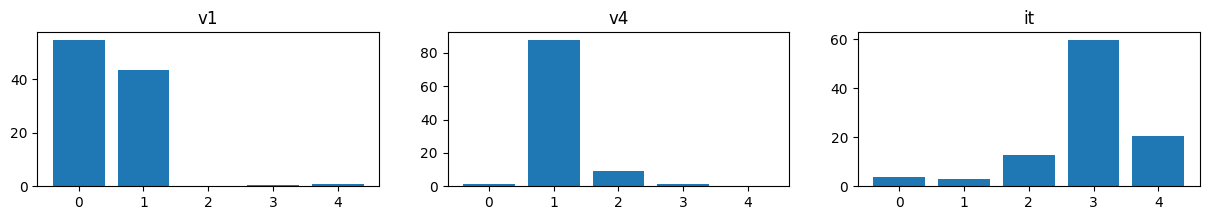

In [ ]:
# Layer assignment: bar plot
norm = [448, 256, 256]
rois = ["all", "v1", "v4", "it"]
fig, axs = plt.subplots(1, 3, figsize=(15, 2))
for roi in range(3):
    values, counts = np.unique(np.argmax(_rs[roi][0], axis=0), return_counts=True)
    _values = np.zeros(len(features))
    _values[values] = counts
    print(roi, np.round(_values / norm[roi] * 100, 2))
    axs[roi].bar(range(len(_values)), _values / norm[roi] * 100)
    axs[roi].set_title(rois[roi+1])
plt.show()

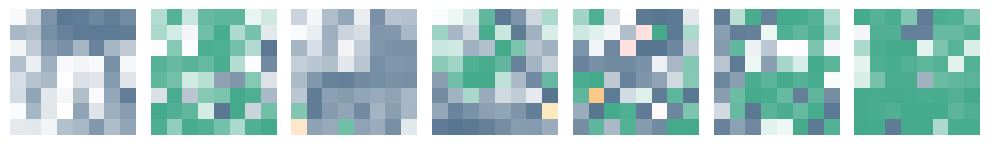

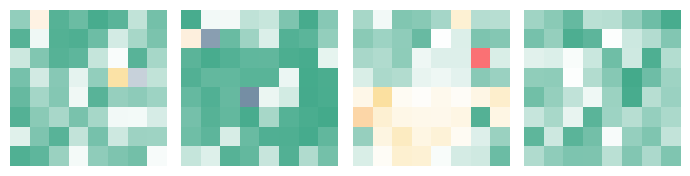

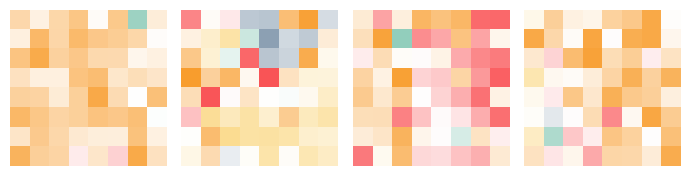

In [ ]:
def plot_electrodes_sign(roi, n):
    fig, axs = plt.subplots(1, n, figsize=(n+3, 3))
    for i in range(n):
        _layer = np.argmax(_rs[roi][0], axis=0)[i*64:(i+1)*64].reshape(8, 8)
        _alpha = np.min((1-_rs[roi][1]), axis=0)[i*64:(i+1)*64].reshape(8, 8)
        im = axs[i].imshow(_layer, cmap=cmap, vmin=0, vmax=5, alpha=_alpha)
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()


# Make a color map of fixed colors
my_colors = ["#577590", "#43AA8B", "#F9C74F", "#F8961E", "#F94144"]
cmap = colors.ListedColormap(my_colors)
bounds = np.arange(len(my_colors))
plot_electrodes_sign(0, 7)
plot_electrodes_sign(1, 4)
plot_electrodes_sign(2, 4)